In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

from IPython.display import clear_output
import statistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

In [295]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [82]:
print(train.shape)
print(train.columns)

print(test.shape)
print(test.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(418, 11)
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Adding features

In [241]:
'''人名/稱謂''' # ['Title_Capt', 'Title_Lady', 'Title_Major', 'Title_Sir', 'Title_the Countess']
train['Title'] = train.Name.str.split(', ').str[1].str.split('.').str[0].str.strip()
train['Title'] = train['Title'].replace({'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Mrs', 
                                         'Rev':'Titled', 'Don':'Titled', 'Dona':'Titled', 'Jonkheer':'Titled', 
                                         'Capt':'Crew', 'Col':'Crew', 'Lady':'Titled', 'Major':'Titled', 
                                         'Sir':'Titled', 'the Countess':'Titled', 'Dr':'Titled'})
'''個人&家庭狀況'''
train['Sex'] = train['Sex'].replace({'female':1, 'male':0})
train['fam_size'] = train['SibSp'] + train['Parch'] + 1
train['Alone'] = (train['fam_size']==1)
train['Alone'] = train['Alone'].astype(int)
train['Married_F'] = (train['Title'] != 'Miss') & (train['Sex'] == 1)
train['sex_class'] = train['Sex'] * train['Pclass']

conditions = [(train['Age'] < 16), (train['Age'] >= 16) & (train['Age'] < 40), 
              (train['Age'] >= 40) & (train['Age'] < 60), (train['Age'] >= 60)]
choices = ['child', 'young', 'midaged', 'old']
train['Age_group'] = np.select(conditions, choices)

'''住宿'''
train['Deck'] = train['Cabin'].str.slice(0, 1)
print(train['Deck'].value_counts())
train['Deck'] = pd.Categorical(train['Deck'], categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
train['Deck'] = train['Deck'].replace({'A':1, 'B':2, 'C':2, 'D':3, 'E':3, 'F':4, 'G':5, 'T':5, 'Z':5})
print(train['Deck'].value_counts())

'''經濟狀況'''
train['fare_perp'] = train['Fare']/train['fam_size']

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Deck, dtype: int64
2.0    106
3.0     65
1.0     15
4.0     13
5.0      5
Name: Deck, dtype: int64


One-way ANOVA preassumptions：
* Normality --> stats.shapiro
* Homoskedasticity --> stats.levene
* Independence --> depends on sampling method
*    reference：https://www.pythonfordatascience.org/anova-python/#anova_scipy_stats



            N     Mean       SD      SE  95% Conf.  Interval
Survived                                                    
0         424  30.6262  14.1721  0.6883    29.2733   31.9790
1         290  28.3437  14.9510  0.8780    26.6157   30.0717
                    sum_sq     df         F    PR(>F)
C(Survived)     897.187582    1.0  4.271195  0.039125
Residual     149559.448362  712.0       NaN       NaN
ShapiroResult(statistic=0.9824720025062561, pvalue=1.533871625269967e-07)


LeveneResult(statistic=1.1953828843934424, pvalue=0.27461621560000243)

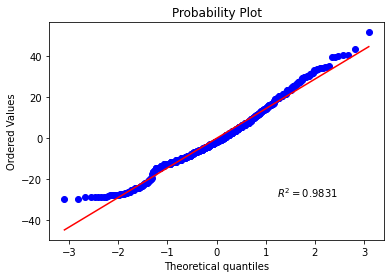

In [10]:
#stats.f_oneway(train[train['Survived'] == 1]['Age'], train[train['Survived'] == 0]['Age'])
print(rp.summary_cont(train['Age'].groupby(train['Survived'])))
model = ols('Age ~ C(Survived)', data=train).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)
print(stats.shapiro(model.resid)) # Did not pass normality test
normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
stats.levene(train['Age'][train['Survived'] == 1].dropna(),
             train['Age'][train['Survived'] == 0].dropna()) # have non-statistically significant varability



            N     Mean       SD      SE  95% Conf.  Interval
Survived                                                    
0         549  22.1179  31.3882  1.3396    19.4865   24.7493
1         342  48.3954  66.5970  3.6012    41.3121   55.4787
                   sum_sq     df          F        PR(>F)
C(Survived)  1.455089e+05    1.0  63.030764  6.120189e-15
Residual     2.052290e+06  889.0        NaN           NaN
ShapiroResult(statistic=0.5871959924697876, pvalue=1.5461927255360032e-41)


LeveneResult(statistic=45.09964096576531, pvalue=3.337352710626e-11)

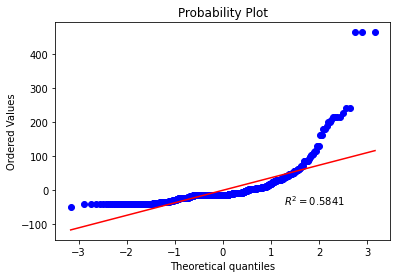

In [11]:
print(rp.summary_cont(train['Fare'].groupby(train['Survived'])))
model = ols('Fare ~ C(Survived)', data=train).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)
print(stats.shapiro(model.resid)) # Did not pass normality test (p-value significant)
normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
stats.levene(train['Fare'][train['Survived'] == 1].dropna(),
             train['Fare'][train['Survived'] == 0].dropna()) # heteroskedasticity



            N    Mean      SD      SE  95% Conf.  Interval
Survived                                                  
0         549  1.8834  1.8307  0.0781     1.7300    2.0369
1         342  1.9386  1.1861  0.0641     1.8124    2.0647
                  sum_sq     df         F    PR(>F)
C(Survived)     0.641445    1.0  0.246193  0.619891
Residual     2316.249688  889.0       NaN       NaN
ShapiroResult(statistic=0.6214359998703003, pvalue=2.708906113324877e-40)


LeveneResult(statistic=0.006444356314184613, pvalue=0.9360352181633312)

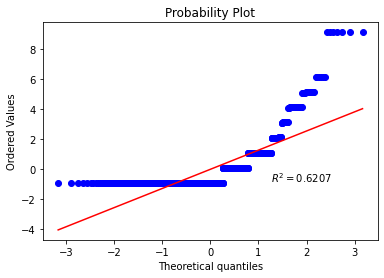

In [12]:
print(rp.summary_cont(train['fam_size'].groupby(train['Survived'])))
model = ols('fam_size ~ C(Survived)', data=train).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table) # insignificant
print(stats.shapiro(model.resid)) # Did not pass normality test (p-value significant)
normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
stats.levene(train['fam_size'][train['Survived'] == 1].dropna(),
             train['fam_size'][train['Survived'] == 0].dropna()) # homoskedasticity

### Chi-Square Test of Independence
* reference：https://predictivehacks.com/how-to-run-chi-square-test-in-python/

Chi-Square： 263.05057407065567 Degree of Freedom： 1 p-value： 3.711747770113424e-59
Reject Null Hypothesis --> Variables are dependent.
Chi-Square： 102.88898875696056 Degree of Freedom： 2 p-value： 4.549251711298793e-23
Reject Null Hypothesis --> Variables are dependent.
Chi-Square： 36.85013084754587 Degree of Freedom： 1 p-value： 1.2756752813177417e-09
Reject Null Hypothesis --> Variables are dependent.


<AxesSubplot:xlabel='Alone', ylabel='Survived'>

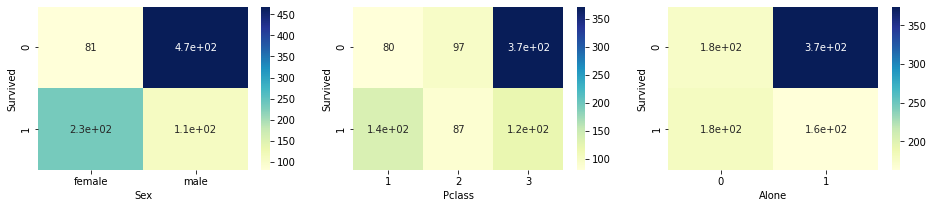

In [13]:
# Construct crosstable # , normalize='index' or 'column' or 'all'--> 百分比
# Null Hypothesis： Variables are independent`
def chi_test(y = train.Survived, x = train.Sex, mar=False):
    y_x = pd.crosstab(y, x, margins=mar)
    chi2, p, dof, ex = stats.chi2_contingency(y_x, correction=False)
    print("Chi-Square：",chi2, "Degree of Freedom：",dof, "p-value：", p)
    if p <= 0.05:
        print("Reject Null Hypothesis --> Variables are dependent.")
    else:
        print("Fail to reject --> Variables may be independent.")
    return y_x

y_sex = chi_test() # Sex & Survived are dependent
y_pclass = chi_test(x=train.Pclass) # Pclass & Survived are dependent
y_alone = chi_test(x=train.Alone) # Alone & Survived are dependent
fig, axs = plt.subplots(1, 3, figsize = (16, 3))

sns.heatmap(y_sex, annot=True, cmap="YlGnBu", ax = axs[0])
sns.heatmap(y_pclass, annot=True, cmap="YlGnBu", ax = axs[1])
sns.heatmap(y_alone, annot=True, cmap="YlGnBu", ax = axs[2])

Chi-Square： 10.300556313502582 Degree of Freedom： 7 p-value： 0.1721713412821439
Fail to reject --> Variables may be independent.


<AxesSubplot:xlabel='Deck', ylabel='Survived'>

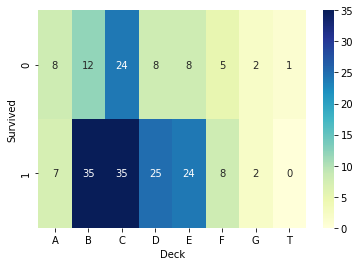

In [14]:
y_deck = chi_test(x=train.Deck) 
sns.heatmap(y_deck, annot=True, cmap="YlGnBu")

In [15]:
# If chi-square test is significant, we then use POST-HOC test to varify group difference
# FWER is the probability of making Type-I error --> use procecure to control FWER
# Bonferroni procedure, Šidák procedure, Tukey's procedure, Holm's step-down procedure, ...
# https://en.wikipedia.org/wiki/Family-wise_error_rate#Controlling_procedures
sp.posthoc_ttest(train, val_col='Survived', group_col='Alone', p_adjust='bonf')
# All three variables are proved to have statistically different groups

,0,1
0,1.000000e+00,9.009490e-10
1,9.009490e-10,1.000000e+00


### Missing Data

In [113]:
#print(train.isnull().sum()) 
# Age、Cabin、Embarked needs Imputation
print(train['Cabin'].isnull().sum())
# --> change Cabin to Deck (categorical)
print(train['Age'].isnull().sum())
# --> fill by 'famsize' mean
print(train['Embarked'].isnull().sum())
# --> fill by mode
print(train['Title'].isnull().sum())

687
177
2
0


##### Embarked

In [121]:
train['Embarked'] = train['Embarked'].fillna(statistics.mode(train['Embarked'].dropna()))

##### Cabin --> Deck
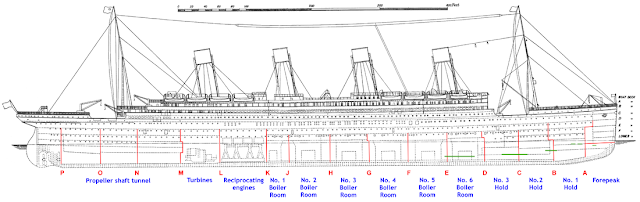
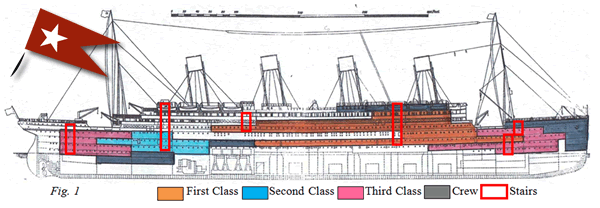

A lot of Cabin data are missing, may deduct that closer to stairs have higher survival.
For categrical variables, we only reserve 'B', 'C', 'D', 'E', 'F', 'Others', 'missing'

(687, 19)


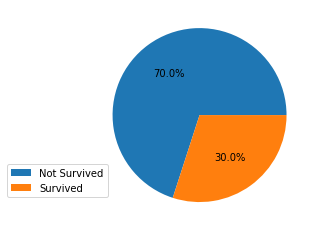

In [122]:
cabin_na = train[train['Cabin'].isna()]
print(cabin_na.shape)
surv_dict = dict(cabin_na['Survived'].value_counts())
plt.pie(surv_dict.values(), autopct='%1.1f%%', radius = 1)
plt.legend(loc = 'lower right', bbox_to_anchor=(0.1, 0.1), 
                 labels = ['Not Survived', 'Survived'])

/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


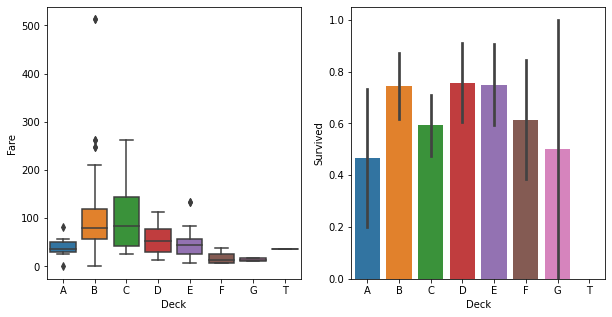

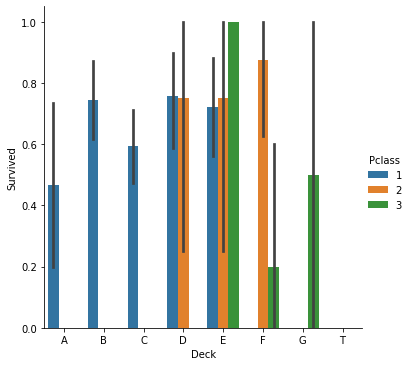

In [94]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))#, sharey = True)
sns.boxplot(train['Deck'], train['Fare'], ax = axs[0])
#sns.boxplot(train['Pclass'], train['Fare'], ax = axs[1])
sns.barplot(train['Deck'], train['Survived'], ax = axs[1])
# No obvious correlation between 'Deck' and 'Pclass'
sns.catplot(data = train, x = 'Deck', y = 'Survived', hue = 'Pclass', kind = 'bar')

In [110]:
#train['Deck'] = train['Deck'].fillna(statistics.mode(train['Deck'].dropna()))
#train['Deck'].isnull().sum()

##### Age

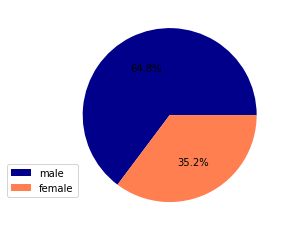

In [240]:
sex_dict = dict(train['Sex'].value_counts())
plt.pie(sex_dict.values(), autopct='%1.1f%%', radius = 1, colors = ['darkblue', 'coral'])
plt.legend(loc = 'lower right', bbox_to_anchor=(0.1, 0.1), 
                 labels = ['male', 'female'])

/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

<AxesSubplot:xlabel='Age_group', ylabel='Survived'>

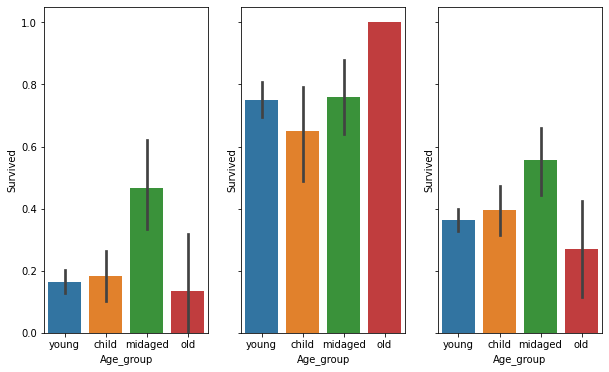

In [247]:
male = train[train['Sex'] == 0]
female = train[train['Sex'] == 1]

fig, axs = plt.subplots(1, 3, figsize = (10, 6), sharey = True, sharex=True)
sns.barplot(train['Age_group'], train['Survived'], ax=axs[2])
sns.barplot(male['Age_group'], male['Survived'], ax=axs[0])
sns.barplot(female['Age_group'], female['Survived'], ax=axs[1])

/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age_group', ylabel='count'>

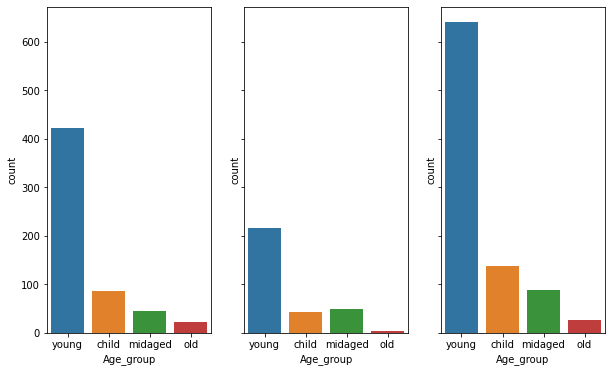

In [248]:
fig, axs = plt.subplots(1, 3, figsize = (10, 6), sharey = True, sharex=True)
sns.countplot(train['Age_group'], ax=axs[2])
sns.countplot(male['Age_group'], ax=axs[0])
sns.countplot(female['Age_group'], ax=axs[1])

(array([23., 11., 42., 50., 93., 35., 24., 19.,  9.,  8.]),
 array([ 0.75 ,  6.975, 13.2  , 19.425, 25.65 , 31.875, 38.1  , 44.325,
        50.55 , 56.775, 63.   ]),
 <BarContainer object of 10 artists>)

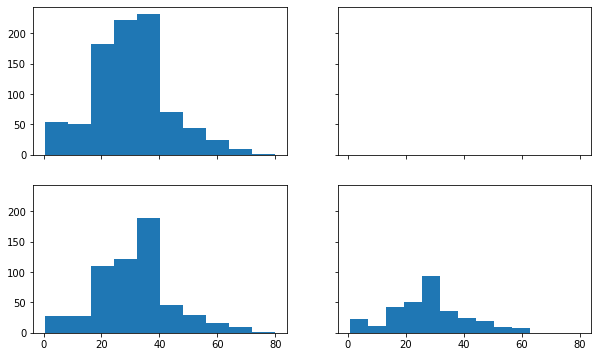

In [224]:
fig, axs = plt.subplots(2, 2, figsize = (10, 6), sharey = True, sharex=True)
axs[0][0].hist(train['Age'])
axs[1][0].hist(male['Age'])
axs[1][1].hist(female['Age'])

/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

<AxesSubplot:xlabel='fam_size', ylabel='Age'>

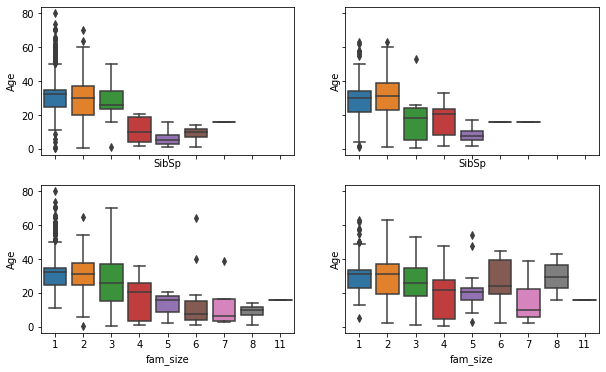

In [72]:
#sns.boxplot(train['Sex'], train['Age']) # similar mean
fig, axs = plt.subplots(2, 2, figsize = (10, 6), sharey = True, sharex = True)
sns.boxplot(male['SibSp'], male['Age'], ax = axs[0][0])
sns.boxplot(male['fam_size'], male['Age'], ax = axs[1][0])
sns.boxplot(female['SibSp'], female['Age'], ax = axs[0][1])
sns.boxplot(female['fam_size'], female['Age'], ax = axs[1][1])

In [250]:
# fill age.na by fam_size age
for ind, row in train.iterrows():
    if ind % 100 == 0:
        clear_output(True)
    if pd.isna(train.loc[ind, 'Age']):
        if train.loc[ind, 'fam_size'] <= 8:
            sex = train.loc[ind, 'Sex']
            famsize = train.loc[ind, 'fam_size']
            same_group = train[(train['fam_size'] == famsize)&(train['Sex'] == sex)]
            age_mean = np.mean(same_group['Age'])
            train.loc[ind, 'Age'] = age_mean
        else:
            sex = train.loc[ind, 'Sex']
            same_group = train[(train['fam_size'] == 8)&(train['Sex'] == sex)]
            age_mean = np.mean(same_group['Age'])
            train.loc[ind, 'Age'] = age_mean

print(train[train['Age'].isnull()])

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, Title, fam_size, Alone, Married_F, sex_class, Deck, fare_perp, Age_group]
Index: []


### Encoding & Scaling

In [259]:
new_train = train.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis = 1)
print(new_train.shape)
numeric = new_train.select_dtypes(include=np.number).columns
category = list(new_train.select_dtypes(include=['object', 'category']).columns)
category = category + ['Deck']
new_train = pd.get_dummies(new_train, columns = list(category), dummy_na = True, drop_first = False)
print(new_train.shape)
print([x for x in new_train.columns if x.startswith("Title")])
new_train = new_train.drop(['Title_nan', 'Embarked_nan', 'Age_group_nan'], axis = 1)
print(new_train.columns)
new_train.head(3)

(891, 16)
(891, 34)
['Title_Crew', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Titled', 'Title_nan']
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'fam_size', 'Alone', 'Married_F', 'sex_class', 'fare_perp',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Crew', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Titled',
       'Age_group_child', 'Age_group_midaged', 'Age_group_old',
       'Age_group_young', 'Deck_1.0', 'Deck_2.0', 'Deck_3.0', 'Deck_4.0',
       'Deck_5.0', 'Deck_nan'],
      dtype='object')


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size,Alone,Married_F,...,Age_group_child,Age_group_midaged,Age_group_old,Age_group_young,Deck_1.0,Deck_2.0,Deck_3.0,Deck_4.0,Deck_5.0,Deck_nan
0,0,3,0,22.0,1,0,7.2500,2,0,False,...,0,0,0,1,0,0,0,0,0,1
1,1,1,1,38.0,1,0,71.2833,2,0,True,...,0,0,0,1,0,1,0,0,0,0
2,1,3,1,26.0,0,0,7.9250,1,1,False,...,0,0,0,1,0,0,0,0,0,1


(array([537., 161., 102.,  29.,  15.,  22.,  12.,   6.,   0.,   7.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

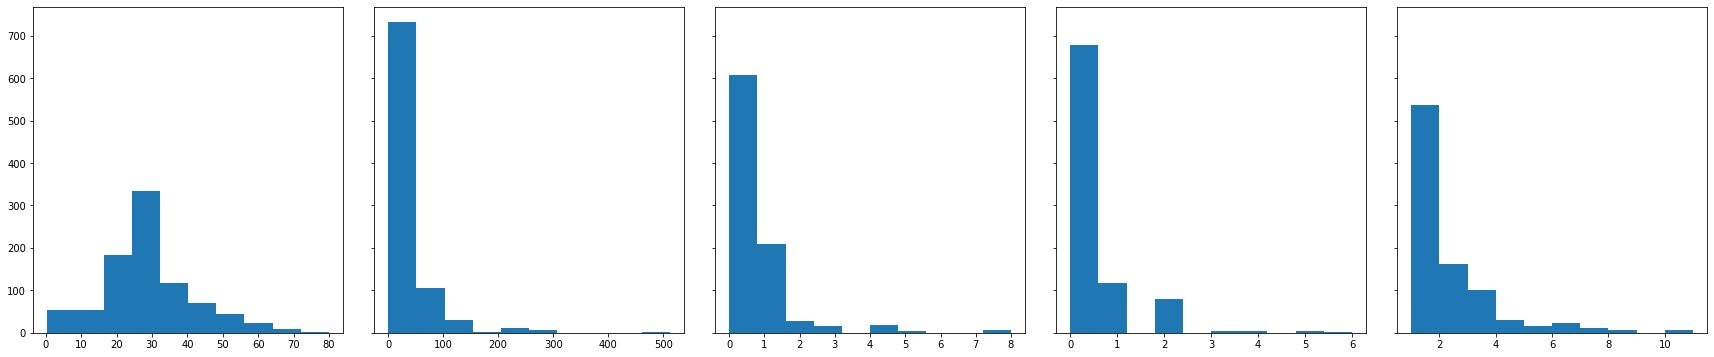

In [75]:
# Looking at (numeric)feature distributions --> 多為偏態
fig, axs = plt.subplots(1, 5, figsize = (30, 6), gridspec_kw = {'wspace':0.1}, sharey = True)
axs[0].hist(train['Age'])
axs[1].hist(train['Fare'])
axs[2].hist(train['SibSp'])
axs[3].hist(train['Parch'])
axs[4].hist(train['fam_size'])

In [260]:
# Use Standardized Scaling
stand_scaler = StandardScaler()
new_train_sd = stand_scaler.fit_transform(new_train)
new_train_sd = pd.DataFrame(new_train_sd, columns = new_train.columns)
print(new_train_sd.shape)
new_train_sd['Survived'] = train['Survived']
new_train_sd.head(3)

(891, 31)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size,Alone,Married_F,...,Age_group_child,Age_group_midaged,Age_group_old,Age_group_young,Deck_1.0,Deck_2.0,Deck_3.0,Deck_4.0,Deck_5.0,Deck_nan
0,0,0.827377,-0.737695,-0.602499,0.432793,-0.473674,-0.502445,0.059160,-1.231645,-0.411450,...,-0.331042,-0.42626,-0.173372,0.626249,-0.130856,-0.367467,-0.280522,-0.121681,-0.075122,0.544925
1,1,-1.566107,1.355574,0.613484,0.432793,-0.473674,0.786845,0.059160,-1.231645,2.430427,...,-0.331042,-0.42626,-0.173372,0.626249,-0.130856,2.721334,-0.280522,-0.121681,-0.075122,-1.835115
2,1,0.827377,1.355574,-0.298503,-0.474545,-0.473674,-0.488854,-0.560975,0.811922,-0.411450,...,-0.331042,-0.42626,-0.173372,0.626249,-0.130856,-0.367467,-0.280522,-0.121681,-0.075122,0.544925


In [26]:
# Use Min-Max Scaling
minmax_scaler = MinMaxScaler()
new_train_minmax = minmax_scaler.fit_transform(new_train)
new_train_minmax = pd.DataFrame(new_train_minmax, columns = new_train.columns)
print(new_train_minmax.shape)
new_train_minmax.head(3)

(891, 30)


,Survived,Pclass,Age,SibSp,Parch,Fare,fam_size,Alone,Married_F,fare_perp,...,Title_Titled,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Z
0,0.0,1.0,0.271174,0.125,0.0,0.014151,0.1,0.0,0.0,0.007076,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.472229,0.125,0.0,0.139136,0.1,0.0,1.0,0.069568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.321438,0.000,0.0,0.015469,0.0,1.0,0.0,0.015469,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([537., 161., 102.,  29.,  15.,  22.,  12.,   6.,   0.,   7.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

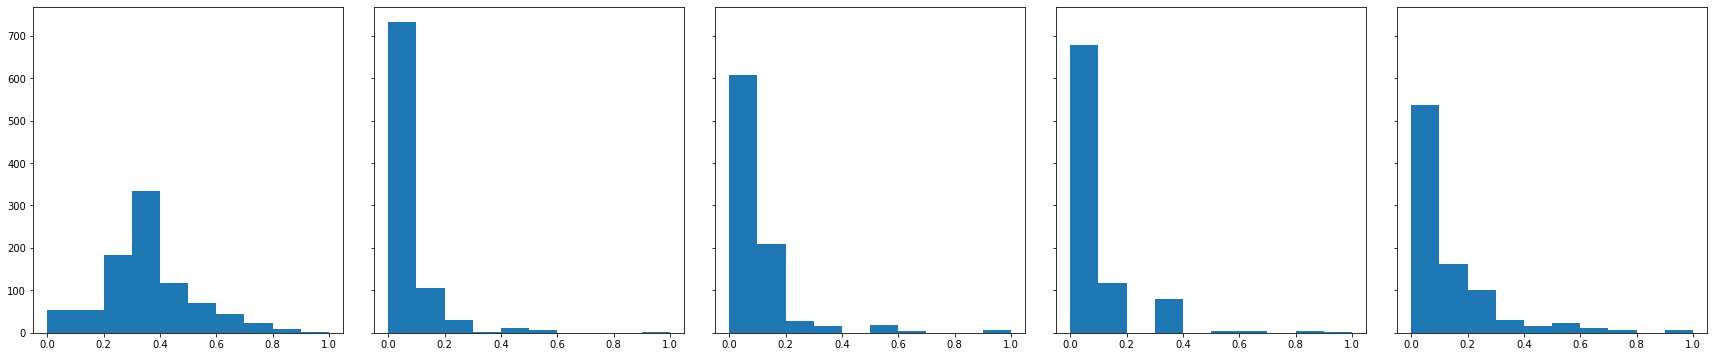

In [27]:
fig, axs = plt.subplots(1, 5, figsize = (30, 6), gridspec_kw = {'wspace':0.1}, sharey = True)
axs[0].hist(new_train_minmax['Age'])
axs[1].hist(new_train_minmax['Fare'])
axs[2].hist(new_train_minmax['SibSp'])
axs[3].hist(new_train_minmax['Parch'])
axs[4].hist(new_train_minmax['fam_size'])

### Feature Selection

/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/josephine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

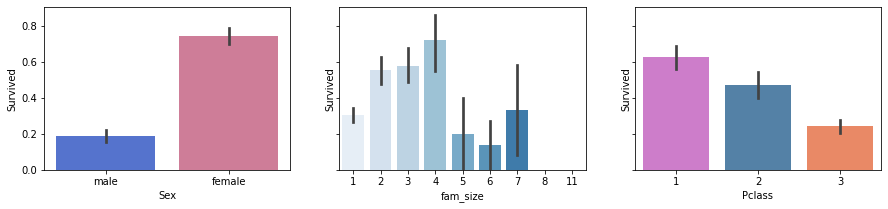

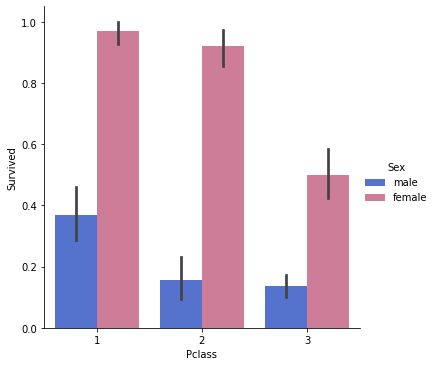

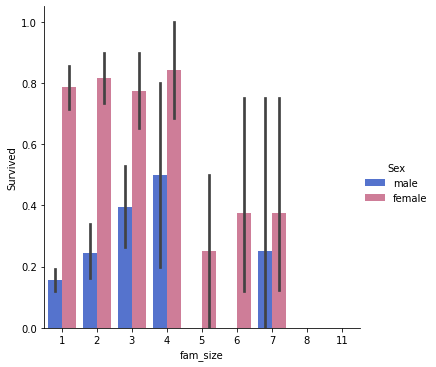

In [56]:
fig, axs = plt.subplots(1, 3, figsize = (15, 3), sharey = True)
sns.barplot(train['Sex'], train['Survived'], ax = axs[0], palette = ['royalblue', 'palevioletred'])
sns.barplot(train['fam_size'], train['Survived'], ax = axs[1], palette = "Blues")
sns.barplot(train['Pclass'], train['Survived'], ax = axs[2], palette = ['orchid', 'steelblue', 'coral'])
plt.show()
sns.catplot(data = train, x = 'Pclass', y = 'Survived', hue = 'Sex', kind = "bar", 
            palette = ['royalblue', 'palevioletred'])
sns.catplot(data = train, x = 'fam_size', y = 'Survived', hue = 'Sex', kind = "bar", 
            palette = ['royalblue', 'palevioletred'])

In [346]:
# check correlation of columns # use 1.correlation 2.PCA to get features
cor = new_train_sd.corr()
high_corr = dict(cor[abs(cor['Survived'].values) >= 0.05]['Survived'].sort_values(ascending=False)[1:])
sel_feats = list(high_corr.keys())
print(sel_feats, len(sel_feats))
print(new_train.columns)

['Sex', 'sex_class', 'Married_F', 'Title_Mrs', 'Title_Miss', 'Fare', 'fare_perp', 'Deck_3.0', 'Deck_2.0', 'Embarked_C', 'Age_group_child', 'Title_Master', 'Parch', 'Deck_4.0', 'Age_group_young', 'Age', 'Embarked_S', 'Alone', 'Deck_nan', 'Pclass', 'Title_Mr'] 21
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'fam_size', 'Alone', 'Married_F', 'sex_class', 'fare_perp',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Crew', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Titled',
       'Age_group_child', 'Age_group_midaged', 'Age_group_old',
       'Age_group_young', 'Deck_1.0', 'Deck_2.0', 'Deck_3.0', 'Deck_4.0',
       'Deck_5.0', 'Deck_nan'],
      dtype='object')


In [338]:
x_train, x_test, y_train, y_test = train_test_split(new_train[sel_feats], 
                                                    new_train_sd['Survived'], 
                                                    test_size = 0.2, random_state = 17)
# new_train_sd.drop('Survived', axis = 1) # new_train[sel_feats]
print("Shape of train x:", x_train.shape)
print("Shape of test x:", x_test.shape)
print("Shape of train y:", y_train.shape)
print("Shape of test y:", y_test.shape)

Shape of train x: (712, 21)
Shape of test x: (179, 21)
Shape of train y: (712,)
Shape of test y: (179,)


In [342]:
xgb = XGBClassifier(n_estimators=5, eval_metric = 'error', #'error',
                    learning_rate = 0.5, reg_lambda = 0.4, max_depth = 5).fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.8044692737430168
Precision:  0.7794117647058824
Confusion Matrix:
 [[91 15]
 [20 53]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       106
           1       0.78      0.73      0.75        73

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



/home/josephine/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [286]:
rdf = RandomForestClassifier(n_estimators = 5, max_depth=5, random_state=0).fit(x_train, y_train)
y_pred = rdf.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.7877094972067039
Precision:  0.7868852459016393
Confusion Matrix:
 [[93 13]
 [25 48]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       106
           1       0.79      0.66      0.72        73

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179



In [285]:
# elasticnet False Positive較多, accuracy不高但precision高
clf = LogisticRegression(solver='saga', penalty='elasticnet', C=0.8, l1_ratio=0.5,
                         random_state=0, class_weight="balanced", max_iter=600).fit(x_train, y_train)
# penalty: 'l1', 'l2', 'elasticnet'; solver:'liblinear', 'saga'
y_pred = clf.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.8100558659217877
Precision:  0.76
Confusion Matrix:
 [[88 18]
 [16 57]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       106
           1       0.76      0.78      0.77        73

    accuracy                           0.81       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.81      0.81      0.81       179



/home/josephine/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [284]:
svclassifier = SVC(C=0.5, kernel='linear', class_weight=None)#"balanced") #'sigmoid', 'poly', 'rbf', 'linear'
svclassifier.fit(x_train, y_train)
y_pred = svclassifier.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy:  0.8044692737430168
Precision:  0.7878787878787878
Confusion Matrix:
 [[92 14]
 [21 52]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       106
           1       0.79      0.71      0.75        73

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [311]:
test = pd.read_csv('test.csv')
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [324]:
'''人名/稱謂''' # ['Title_Capt', 'Title_Lady', 'Title_Major', 'Title_Sir', 'Title_the Countess']
test['Title'] = test.Name.str.split(', ').str[1].str.split('.').str[0].str.strip()
test['Title'] = test['Title'].replace({'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Mrs', 
                                         'Rev':'Titled', 'Don':'Titled', 'Dona':'Titled', 'Jonkheer':'Titled', 
                                         'Capt':'Crew', 'Col':'Crew', 'Lady':'Titled', 'Major':'Titled', 
                                         'Sir':'Titled', 'the Countess':'Titled', 'Dr':'Titled'})
'''個人&家庭狀況'''
test['Sex'] = test['Sex'].replace({'female':1, 'male':0})
test['fam_size'] = test['SibSp'] + test['Parch'] + 1
test['Alone'] = (test['fam_size']==1)
test['Alone'] = test['Alone'].astype(int)
test['Married_F'] = (test['Title'] != 'Miss') & (test['Sex'] == 1)
test['sex_class'] = test['Sex'] * test['Pclass']

conditions = [(test['Age'] < 16), (test['Age'] >= 16) & (test['Age'] < 40), 
              (test['Age'] >= 40) & (test['Age'] < 60), (test['Age'] >= 60)]
choices = ['child', 'young', 'midaged', 'old']
test['Age_group'] = np.select(conditions, choices)

'''住宿'''
test['Deck'] = test['Cabin'].str.slice(0, 1)
print(test['Deck'].value_counts())
test['Deck'] = pd.Categorical(test['Deck'], categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
test['Deck'] = test['Deck'].replace({'A':1, 'B':2, 'C':2, 'D':3, 'E':3, 'F':4, 'G':5, 'T':5, 'Z':5})
print(test['Deck'].value_counts())

'''經濟狀況'''
test['Fare'] = test.fillna(np.mean(test['Fare']))
test['fare_perp'] = test['Fare']/test['fam_size']

# fill age.na by fam_size age
for ind, row in test.iterrows():
    if ind % 100 == 0:
        clear_output(True)
    if pd.isna(test.loc[ind, 'Age']):
        if test.loc[ind, 'fam_size'] <= 8:
            sex = test.loc[ind, 'Sex']
            famsize = test.loc[ind, 'fam_size']
            same_group = test[(test['fam_size'] == famsize)&(test['Sex'] == sex)]
            age_mean = np.mean(same_group['Age'])
            test.loc[ind, 'Age'] = age_mean
        else:
            sex = test.loc[ind, 'Sex']
            same_group = test[(test['fam_size'] == 8)&(test['Sex'] == sex)]
            age_mean = np.mean(same_group['Age'])
            test.loc[ind, 'Age'] = age_mean

print(test[test['Age'].isnull()])

Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, Title, fam_size, Alone, Married_F, sex_class, Age_group, Deck, fare_perp]
Index: []


In [331]:
new_test = test.drop(['Ticket', 'Cabin', 'Name', 'PassengerId', 'Fare', 'fare_perp'], axis = 1)
print(new_test.shape)
numeric = list(new_test.select_dtypes(include=np.number).columns)
numeric = numeric + ['Fare', 'fare_perp']
print(numeric)
category = list(new_test.select_dtypes(include=['object', 'category']).columns)
category = category + ['Deck']
new_test = pd.get_dummies(new_test, columns = list(category), dummy_na = True, drop_first = False)
print(new_test.shape)
print([x for x in new_test.columns if x.startswith("Title")])
new_test = new_test.drop(['Title_nan', 'Embarked_nan', 'Age_group_nan', 'SibSp'], axis = 1)
new_test['Fare'] = test['Fare']
new_test['fare_perp'] = test['fare_perp']
print(new_test.columns)
new_test.head(3)

(418, 13)
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'fam_size', 'Alone', 'sex_class', 'Deck', 'Fare', 'fare_perp']
(418, 31)
['Title_Crew', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Titled', 'Title_nan']
Index(['Pclass', 'Sex', 'Age', 'Parch', 'fam_size', 'Alone', 'Married_F',
       'sex_class', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Crew',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Titled',
       'Age_group_child', 'Age_group_midaged', 'Age_group_old',
       'Age_group_young', 'Deck_1.0', 'Deck_2.0', 'Deck_3.0', 'Deck_4.0',
       'Deck_5.0', 'Deck_nan', 'Fare', 'fare_perp'],
      dtype='object')


,Pclass,Sex,Age,Parch,fam_size,Alone,Married_F,sex_class,Embarked_C,Embarked_Q,...,Age_group_old,Age_group_young,Deck_1.0,Deck_2.0,Deck_3.0,Deck_4.0,Deck_5.0,Deck_nan,Fare,fare_perp
0,3,0,34.5,0,1,1,False,0,0,1,...,0,1,0,0,0,0,0,1,892,892.0
1,3,1,47.0,0,2,0,True,3,0,0,...,0,0,0,0,0,0,0,1,893,446.5
2,2,0,62.0,0,1,1,False,0,0,1,...,1,0,0,0,0,0,0,1,894,894.0


In [332]:
# Use Standardized Scaling
new_test_sd = stand_scaler.fit_transform(new_test)
new_test_sd = pd.DataFrame(new_test_sd, columns = new_test.columns)
print(new_test_sd.shape)
new_test_sd.head(3)

# Use Min-Max Scaling
new_test_minmax = minmax_scaler.fit_transform(new_test)
new_test_minmax = pd.DataFrame(new_test_minmax, columns = new_test.columns)
print(new_test_minmax.shape)
new_test_minmax.head(3)

(418, 29)
(418, 29)


,Pclass,Sex,Age,Parch,fam_size,Alone,Married_F,sex_class,Embarked_C,Embarked_Q,...,Age_group_old,Age_group_young,Deck_1.0,Deck_2.0,Deck_3.0,Deck_4.0,Deck_5.0,Deck_nan,Fare,fare_perp
0,1.0,0.0,0.452723,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.656147
1,1.0,1.0,0.617566,0.0,0.1,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.002398,0.287910
2,0.5,0.0,0.815377,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.004796,0.657800


In [343]:
test_pred = xgb.predict(new_test_sd[sel_feats])
test_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [344]:
submission = pd.DataFrame(columns = ['PassengerId', 'Survived'])
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = test_pred
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [345]:
submission.to_csv('submission.csv', index = False)